## **cement strenght prediction model** ##


In [4]:
# Importing Data Manipulation Libraries
import pandas as pd
import numpy as np
# Import Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt 
# Import Filter Warning Libraries
import warnings
warnings.filterwarnings('ignore')
# Import Logging
import logging
logging.basicConfig(level = logging.INFO,
                    format = '%(asctime)s - %(levelname)s - %(message)s',
                    filemode = 'w',
                    filename = 'model.log',force = True)
# Import Scikit Learn Libraries for Machine Learning Model Building
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve,KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.cluster import KMeans


# Multicolinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [18]:
df = pd.read_csv(r'C:\Cement_Strenght_Prediction_Model\data\raw\Concrete_Compressive_Strength.csv')
df.sample(frac = 1)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,water_cement_ratio,total_binder,aggregate_to_cement,cement_water_interaction,age_strength_proxy
205,122.6,183.9,0.0,203.5,0.0,958.2,800.1,28,24.29,1.659856,306.5,14.341645,24949.10,5.291503
213,212.0,0.0,124.8,159.0,7.8,1085.4,799.5,3,19.52,0.749996,336.8,8.890996,33708.00,1.732051
337,286.3,200.9,0.0,144.7,11.2,1004.6,803.7,91,76.80,0.505412,487.2,6.316080,41427.61,9.539392
440,275.1,0.0,121.4,159.5,9.9,1053.6,777.5,14,38.77,0.579787,396.5,6.656101,43878.45,3.741657
501,339.0,0.0,0.0,185.0,0.0,1060.0,754.0,28,31.65,0.545721,339.0,5.351017,62715.00,5.291503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,159.0,209.0,161.0,201.0,7.0,848.0,669.0,28,30.88,1.264143,529.0,9.540820,31959.00,5.291503
247,213.7,0.0,174.7,154.8,10.2,1053.5,776.4,28,40.15,0.724377,388.4,8.562899,33080.76,5.291503
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.299999,540.0,3.177772,87480.00,5.291503
248,200.0,0.0,0.0,180.0,0.0,1125.0,845.0,28,12.25,0.899996,200.0,9.849951,36000.00,5.291503


In [6]:
# Creating Our First Log
logging.info('Dataset Imported Successfully For Model Building...')

In [19]:
# Checking Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cement                    1030 non-null   float64
 1   slag                      1030 non-null   float64
 2   ash                       1030 non-null   float64
 3   water                     1030 non-null   float64
 4   superplastic              1030 non-null   float64
 5   coarseagg                 1030 non-null   float64
 6   fineagg                   1030 non-null   float64
 7   age                       1030 non-null   int64  
 8   strength                  1030 non-null   float64
 9   water_cement_ratio        1030 non-null   float64
 10  total_binder              1030 non-null   float64
 11  aggregate_to_cement       1030 non-null   float64
 12  cement_water_interaction  1030 non-null   float64
 13  age_strength_proxy        1030 non-null   float64
dtypes: float

In [20]:
df['age'] = df['age'].astype('float64')

In [21]:
from collections import OrderedDict

stats = []

# Descriptive statistics
for col in df.columns:
    if df[col].dtype != 'object':
        numerical_stats = OrderedDict({
            'Feature': col,
            'Minimum': df[col].min(),
            'Maximum': df[col].max(),
            'Mean': df[col].mean(),
            'Mode': df[col].mode()[0] if not df[col].mode().empty else None,
            '25%': df[col].quantile(0.25),
            '75%': df[col].quantile(0.75),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Standard Deviation': df[col].std(),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurt()
        })
        stats.append(numerical_stats)

# Convert to DataFrame
report = pd.DataFrame(stats)

# Outlier Identification :
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

# Checking Report
report

,Feature,Minimum,Maximum,Mean,Mode,25%,75%,IQR,Standard Deviation,Skewness,Kurtosis,Outlier Comment
0,cement,102.000000,540.000000,281.167864,362.600000,192.375000,350.000000,157.625000,104.506364,0.509481,-0.520652,No Outliers
1,slag,0.000000,359.400000,73.895825,0.000000,0.000000,142.950000,142.950000,86.279342,0.800717,-0.508175,Has Outliers
2,ash,0.000000,200.100000,54.188350,0.000000,0.000000,118.300000,118.300000,63.997004,0.537354,-1.328746,No Outliers
3,water,121.800000,247.000000,181.567282,192.000000,164.900000,192.000000,27.100000,21.354219,0.074628,0.122082,Has Outliers
4,superplastic,0.000000,32.200000,6.204660,0.000000,0.000000,10.200000,10.200000,5.973841,0.907203,1.411269,Has Outliers
5,coarseagg,801.000000,1145.000000,972.918932,932.000000,932.000000,1029.400000,97.400000,77.753954,-0.040220,-0.599016,No Outliers
6,fineagg,594.000000,992.600000,773.580485,594.000000,730.950000,824.000000,93.050000,80.175980,-0.253010,-0.102177,Has Outliers
7,age,1.000000,365.000000,45.662136,28.000000,7.000000,56.000000,49.000000,63.169912,3.269177,12.168989,Has Outliers
8,strength,2.330000,82.600000,35.817961,33.400000,23.710000,46.135000,22.425000,16.705742,0.416977,-0.313725,Has Outliers
9,water_cement_ratio,0.266892,1.882334,0.748263,0.454770,0.533332,0.935160,0.401828,0.314003,0.958065,0.734109,Has Outliers


In [22]:
# Replace Outliers with Median Statergy

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        replacement = df[col].median()  
        df.loc[outliers, col] = replacement
        print(f"Replaced {outlier_count} outliers in '{col}' with median.")
    else:
        print(f"No outliers found in '{col}'.")

No outliers found in 'cement'.
Replaced 2 outliers in 'slag' with median.
No outliers found in 'ash'.
Replaced 9 outliers in 'water' with median.
Replaced 10 outliers in 'superplastic' with median.
No outliers found in 'coarseagg'.
Replaced 5 outliers in 'fineagg' with median.
Replaced 59 outliers in 'age' with median.
Replaced 4 outliers in 'strength' with median.
Replaced 18 outliers in 'water_cement_ratio' with median.
No outliers found in 'total_binder'.
Replaced 8 outliers in 'aggregate_to_cement' with median.
No outliers found in 'cement_water_interaction'.
Replaced 33 outliers in 'age_strength_proxy' with median.


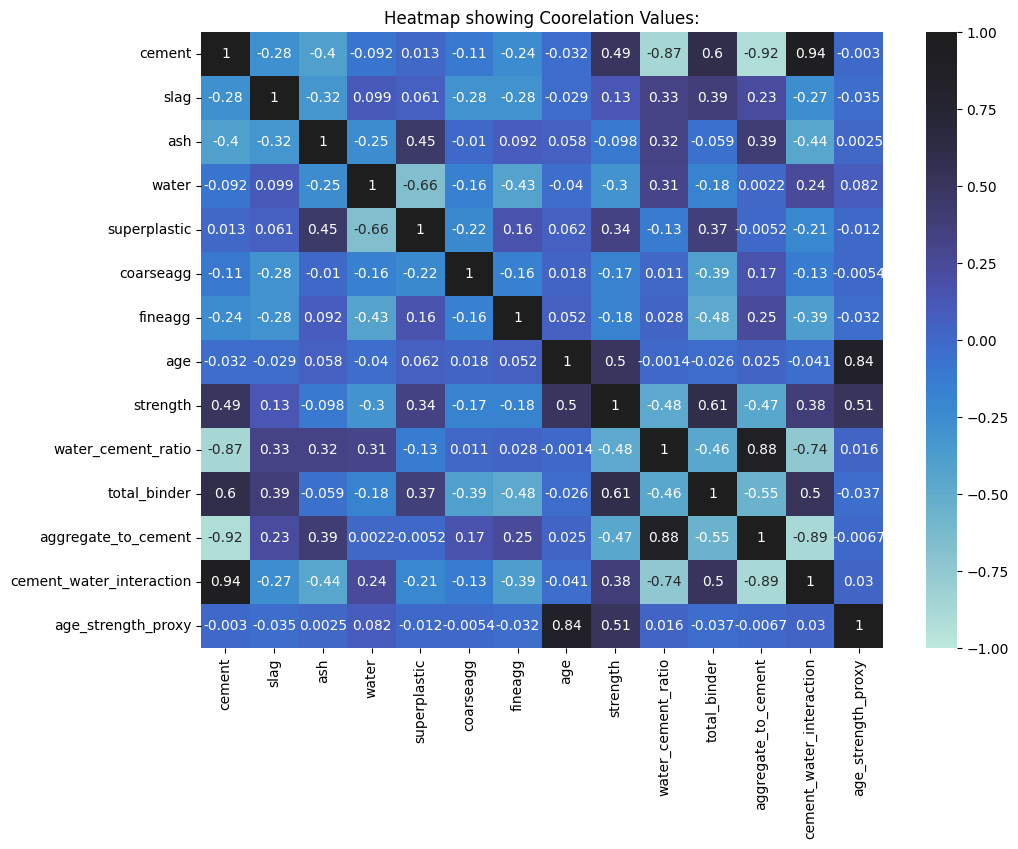

In [25]:
# Checking Correlation 
corr = df.corr()
df.ax = plt.subplots(figsize = (11,8))
sns.heatmap(corr,annot = True,center = True,vmax= 1,vmin = -1)
plt.title('Heatmap showing Coorelation Values:')
plt.show()